# Dementia Evaluation

Notebook for evaluating pretrained models.

In [1]:
import os, random, time, numpy as np, pandas as pd, copy
import tensorflow as tf
from tensorflow import losses, optimizers, metrics
from tensorflow.keras import Input, Model, layers, callbacks, regularizers, models
from jarvis.train import custom, datasets, params
from jarvis.train.client import Client
from jarvis.utils.general import gpus, overload, tools as jtools
from jarvis.utils.display import imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import pearsonr

In [2]:
# --- Autoselect GPU
gpus.autoselect()

[ 2021-08-25 15:54:28 ] WARNING 1 GPU device(s) requested but only 0 available 


## Load pretrained model

In [3]:
# --- Initialize client
client = Client('/home/mmorelan/proj/dementia/yml/client-3d-96x128.yml', configs={'batch': {'fold': 0}})

In [4]:
# --- Load contrastive model
pretrained_model = models.load_model("../train/96x128/lr_tuner_mae/03/model.hdf5", compile=False, custom_objects={'tf': tf})
pretrained_model.summary()

/miniconda/envs/jarvis/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: loss is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos (InputLayer)                [(None, 96, 128, 128 0                                            
__________________________________________________________________________________________________
unk (InputLayer)                [(None, 96, 128, 128 0                                            
__________________________________________________________________________________________________
neg (InputLayer)                [(None, 96, 128, 128 0                                            
__________________________________________________________________________________________________
model (Functional)              {'ctr': (None, 10),  199978      pos[0][0]                        
                                                                 unk[0][0]                  

In [5]:
pretrained_model.input

{'pos': <KerasTensor: shape=(None, 96, 128, 128, 1) dtype=float32 (created by layer 'pos')>,
 'unk': <KerasTensor: shape=(None, 96, 128, 128, 1) dtype=float32 (created by layer 'unk')>,
 'neg': <KerasTensor: shape=(None, 96, 128, 128, 1) dtype=float32 (created by layer 'neg')>}

### Refine model

At test time, we are only given one unknown 3D volume scan. Thus, we need to remove some model inputs and their associated layers.

In [6]:
# --- Get single input model
enc_model = Model(inputs=pretrained_model.input['unk'], outputs=pretrained_model.get_layer('enc2').output)
dec_model = Model(inputs=pretrained_model.input['unk'], outputs=pretrained_model.get_layer('dec2').output)

In [7]:
enc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unk (InputLayer)             [(None, 96, 128, 128, 1)] 0         
_________________________________________________________________
model (Functional)           {'ctr': (None, 10), 'enc' 199978    
_________________________________________________________________
enc2 (Layer)                 (None, 1)                 0         
Total params: 199,978
Trainable params: 199,658
Non-trainable params: 320
_________________________________________________________________


In [8]:
dec_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unk (InputLayer)             [(None, 96, 128, 128, 1)] 0         
_________________________________________________________________
model (Functional)           {'ctr': (None, 10), 'enc' 199978    
_________________________________________________________________
dec2 (Layer)                 (None, 96, 128, 128, 1)   0         
Total params: 199,978
Trainable params: 199,658
Non-trainable params: 320
_________________________________________________________________


## Load testing data

In [9]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True)

In [10]:
# --- Aggregate all examples
xs = []
ys = []

for x, y in test_valid:
    xs.append(x['dat'])
    ys.append(y['lbl'])

xs = np.concatenate(xs)
ys = np.concatenate(ys)

[ 2021-08-25 15:55:13 ] [====================] 100.000% : Iterating | 000669    

## Forward pass over entire dataset

* The model outputs from the encoder (classification) and decoder (reconstruction) will be saved in `logits`.
* This step will take some time... you may either subsample the data or wait patiently.
* You may also create a model with two outputs which will reduce the amount of forward passes:

```python
model = Model(inputs=pretrained_model.input['unk'], outputs=[pretrained_model.get_layer('enc2').output, 
                                                             pretrained_model.get_layer('dec2').output,])
```

In [11]:
# --- Run prediction over all samples (takes some time, recommend to subsample the data...)
logits = {'enc2': enc_model.predict(xs), 'dec2': dec_model.predict(xs)}

In [12]:
# --- Calculate metrics

def classification(true, y_pred):
    # --- Binarize probability predictions using a 0.5 threshold
    pred = copy.deepcopy(y_pred)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1
    
    df = pd.DataFrame()
    df['pred'] = np.squeeze(pred)
    df['true'] = np.squeeze(true)
    df['corr'] = df['pred'] == df['true']
    
    return df


def reconstruction(true, y_pred):
    assert len(true) == len(y_pred)
    
    df = pd.DataFrame()
    df['mae'] = np.array([np.mean(abs(true - y_pred))])
    df['mse'] = np.array([np.mean((true - y_pred)**2)])
    
    return df

## Reconstruction results

In [13]:
def show_reconstruction(true, pred, figsize=(10, 10)):

    imshow(true, figsize=figsize)
    
    if pred.shape == 4:
        imshow(pred[None, :], figsize=figsize)
        imshow(true, pred[None, :], figsize=figsize) # overlay
    else:
        imshow(pred, figsize=figsize)
        imshow(true, pred, figsize=figsize) # overlay

In [14]:
def relu(x):
    return np.clip(x, a_min=0, a_max=None)

### Visualizing reconstruction

1. Original scan
2. Reconstructed scan
3. Overlay of reconstructed scan on top of original

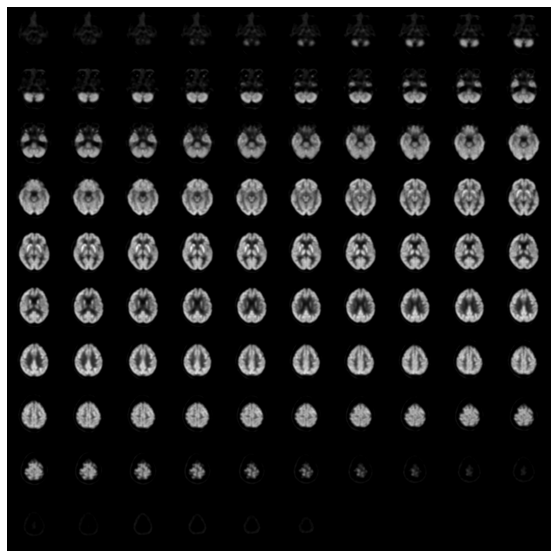

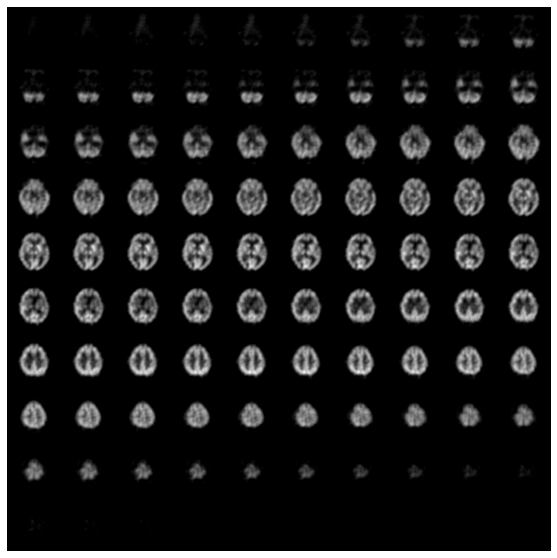

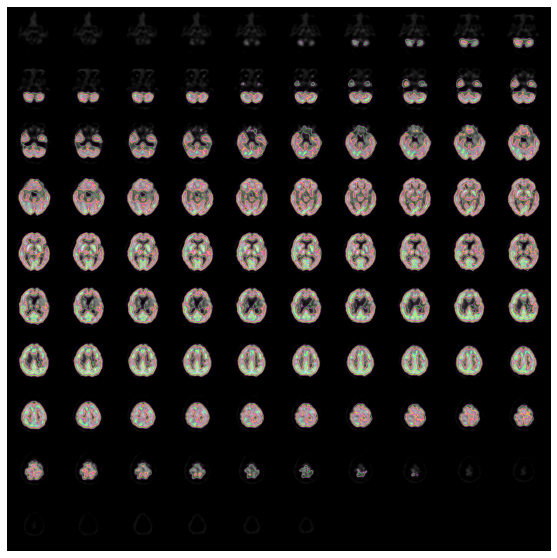

In [15]:
show_reconstruction(relu(xs[0]), relu(logits['dec2'][0]))

### Prediction Ground-truth correlation

Each datapoint corresponds to the mean over an entire scan.

In [16]:
def plot_correlation(true, pred):
    plt.scatter(true.squeeze(), pred.squeeze())
    plt.xlabel('ground-truth')
    plt.ylabel('reconstructed')
    plt.show()

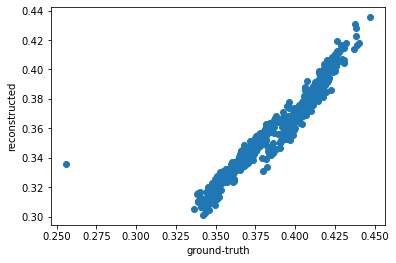

(0.9644532338562889, 0.0)

In [17]:
Xrelu_original = np.mean(relu(xs), axis=(1,2,3,4)) 
Xrelu_reconstr = np.mean(relu(logits['dec2']), axis=(1,2,3,4))

plot_correlation(Xrelu_original, Xrelu_reconstr)
pearsonr(Xrelu_original, Xrelu_reconstr)

In [18]:
# --- Get rid of that loner outlier!
outlier_ind = np.argmin(Xrelu_original)

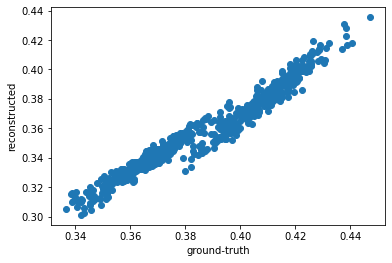

(0.9779721800459811, 0.0)

In [19]:
# --- Recompute without outlier
Xrelu_original_new = Xrelu_original[Xrelu_original != Xrelu_original[outlier_ind]]
Xrelu_reconstr_new = Xrelu_reconstr[Xrelu_original != Xrelu_original[outlier_ind]]

plot_correlation(Xrelu_original_new, Xrelu_reconstr_new)
pearsonr(Xrelu_original_new, Xrelu_reconstr_new)

### 1D reconstruction

1. Original scan
2. Reconstructed scan

In [20]:
def plot_regression(X, color):
    plt.plot(X.squeeze(), color=color)
    print(f"mean: {X.mean()}, std: {X.std()}")
    plt.show()

mean: 0.3849503695964813, std: 0.025005685165524483


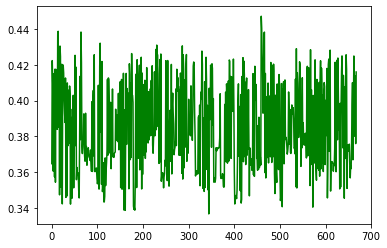

In [21]:
# --- Original data
plot_regression(X=Xrelu_original_new, color='green')

mean: 0.3566315770149231, std: 0.027279453352093697


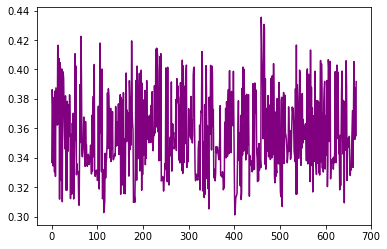

In [22]:
# --- Reconstructed data
plot_regression(X=Xrelu_reconstr_new, color='purple')

## Classification results

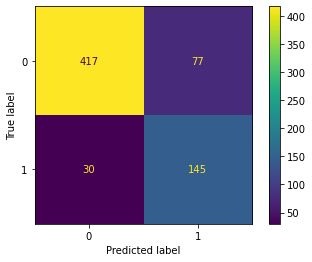

In [28]:
# --- Confusion matrix
y_pred = copy.deepcopy(logits['enc2'])
y_pred[y_pred >= .5] = 1
y_pred[y_pred < .5] = 0

matrix = confusion_matrix(ys.squeeze(), y_pred.squeeze())
cmd = ConfusionMatrixDisplay(matrix)
cmd.plot()

In [42]:
TN, FP, FN, TP = matrix.flatten()
sen = TP / (TP + FN) # recall
spe = TN / (TN + FP)
ppv = TP / (TP + FP) # precision
npv = TN / (FN + TN)
f1  = (2 * (ppv * sen)) / (ppv + sen)

In [43]:
sen, spe, ppv, npv, f1

(0.8285714285714286,
 0.8441295546558705,
 0.6531531531531531,
 0.9328859060402684,
 0.7304785894206549)

### Final results

In [44]:
# --- Reconstruction Accuracy
df = reconstruction(xs[0:10], logits['dec2'][0:10])

# --- Classification Accuracy 
acc = classification(ys, logits['enc2'])
df['mean_acc'] = acc['corr'].mean()
df['median_acc'] = np.median(acc['corr'])
df['recall'] = sen
df['precision'] = ppv 
df['f1'] = f1

In [45]:
df

,mae,mse,mean_acc,median_acc,recall,precision,f1
0,0.158433,0.062638,0.84006,1.0,0.828571,0.653153,0.730479
